#  <center>Flu Shot Learning: Predicting H1N1 and Seasonal Flu Vaccines</center>
## <center>A [DrivenData](https://www.drivendata.org/) Challenge </center>

## <center>Introduction</center>

**<center> 
The objective of this challenge is to predict how likely individuals are to receive their H1N1 and seasonal flu vaccines. We are providing a probability prediction for each vaccine. The performance metric for our model will be the area under the receiver operating characteristic curve (ROC AUC). This is the metric that the competition will be using to evaluate our submission.**
</center>

## 0.0 Loading Our Necessary Libraries

In [134]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier




from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

## 1.0 Data Exploration 
### Let's take a look at our data before we begin working  with it

## 1.1 Loading the data

In [135]:
data_dir = 'datasets/' # Our datasets directory 

train_features = pd.read_csv(data_dir+'training_set_features.csv',index_col='respondent_id')
train_labels   = pd.read_csv(data_dir+'training_set_labels.csv',index_col='respondent_id')
test_features  = pd.read_csv(data_dir+'test_set_features.csv', index_col='respondent_id')

In [136]:
train_features.head(5) # Take a look at our training features 

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [137]:
train_labels.head(5) # Take a look at our training labels

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [138]:
# We see that our training features have  some null or NaN values
# Let's handle columns that may have an excess amount of these  values 
null_threshold = 0.15 # Drop columns where more than 15% of our data is missing values


null_rate = train_features.isnull().sum(axis=0) / len(train_features) # get the rate of NaN or Null appearances for each column.
null_bool = null_rate > null_threshold # Return a boolean pd.Series of whether or not each column had a null rate greater than our threshold
null_cols = list(null_bool[null_bool == True].index) # Create a list of the columns that had a null rate greater than our threshold. 

null_cols # Take a look at the columns with a null rate greater than our threshold defined above

['health_insurance',
 'income_poverty',
 'employment_industry',
 'employment_occupation']

In [139]:
# Let's create a helper function that drops the columns with a null rate
# greater than a given threshold 

def drop_null_threshold(df: pd.DataFrame, null_threshold = 0.15):

    null_rate = train_features.isnull().sum(axis=0) / len(train_features) # get the rate of NaN or Null appearances for each column.
    null_bool = null_rate > null_threshold # Return a boolean pd.Series of whether or not each column had a null rate greater than our threshold
    null_cols = list(null_bool[null_bool == True].index) 
    print('Columns dropped:\n', null_cols)
    
    # Drop columns with null rate greather than threshold
    df.drop(null_cols,
                    axis=1,
                    inplace=True)
    return None

In [140]:
# Remove columns with excess null values from our test and training feature dataframes
# drop_null_threshold(train_features)
# drop_null_threshold(test_features)

In [141]:
numeric_cols = train_features.select_dtypes(include=np.number)
numeric_cols.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,2.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,0.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,1.0,0.0


In [142]:
non_numeric_cols =  train_features.select_dtypes(exclude=np.number)
numeric_cols.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,2.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,0.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,1.0,0.0


In [143]:
numeric_cols.isnull().values.any()

True

In [144]:
# Handle NaNs 
numeric_cols = numeric_cols.fillna(numeric_cols.median())

In [145]:
numeric_cols.isnull().values.any()

False

In [146]:
list(numeric_cols.columns)

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [147]:
train = numeric_cols.merge(train_labels, on='respondent_id')



num_correlations = train.corr()
num_correlations.sort_values('h1n1_vaccine',ascending=False)['h1n1_vaccine']


h1n1_vaccine                   1.000000
doctor_recc_h1n1               0.394086
seasonal_vaccine               0.377143
opinion_h1n1_risk              0.320580
opinion_h1n1_vacc_effective    0.267352
opinion_seas_risk              0.255874
doctor_recc_seasonal           0.218976
opinion_seas_vacc_effective    0.177799
health_worker                  0.168056
h1n1_concern                   0.121574
h1n1_knowledge                 0.117771
chronic_med_condition          0.094360
opinion_h1n1_sick_from_vacc    0.074580
behavioral_wash_hands          0.074570
behavioral_touch_face          0.070855
behavioral_face_mask           0.070413
child_under_6_months           0.066712
behavioral_avoidance           0.046837
health_insurance               0.041891
behavioral_antiviral_meds      0.040226
behavioral_outside_home        0.022080
behavioral_large_gatherings    0.018089
opinion_seas_sick_from_vacc    0.008415
household_adults               0.007323
household_children            -0.002567


In [148]:
num_correlations.sort_values('seasonal_vaccine',ascending=False)['seasonal_vaccine']

seasonal_vaccine               1.000000
opinion_seas_risk              0.386916
h1n1_vaccine                   0.377143
doctor_recc_seasonal           0.360696
opinion_seas_vacc_effective    0.358869
opinion_h1n1_risk              0.215650
opinion_h1n1_vacc_effective    0.203187
doctor_recc_h1n1               0.198560
chronic_med_condition          0.169465
h1n1_concern                   0.154488
health_worker                  0.126977
health_insurance               0.124929
behavioral_touch_face          0.119925
h1n1_knowledge                 0.119779
behavioral_wash_hands          0.112254
behavioral_avoidance           0.076130
behavioral_large_gatherings    0.063722
behavioral_outside_home        0.053287
behavioral_face_mask           0.050020
opinion_h1n1_sick_from_vacc    0.027964
child_under_6_months           0.013424
behavioral_antiviral_meds      0.006013
opinion_seas_sick_from_vacc   -0.060538
household_adults              -0.065137
household_children            -0.111680


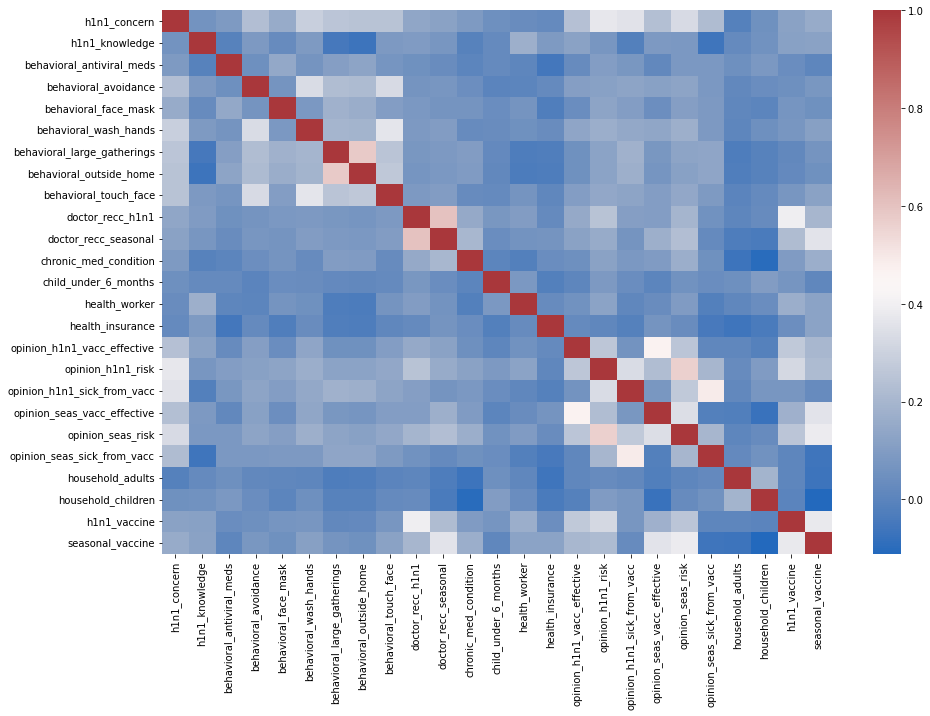

In [149]:
plt.figure(figsize=(15, 10))
colormap = sns.color_palette("vlag", as_cmap=True)
h1n1_heat = sns.heatmap(num_correlations, cmap=colormap)

In [150]:
non_numeric_cols

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...
26702,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,NaN,NaN
26703,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",fcxhlnwr,cmhcxjea
26704,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",NaN,NaN


In [151]:
non_numeric_cols = non_numeric_cols.apply(LabelEncoder().fit_transform)

In [152]:
non_num_corr = non_numeric_cols.corr()

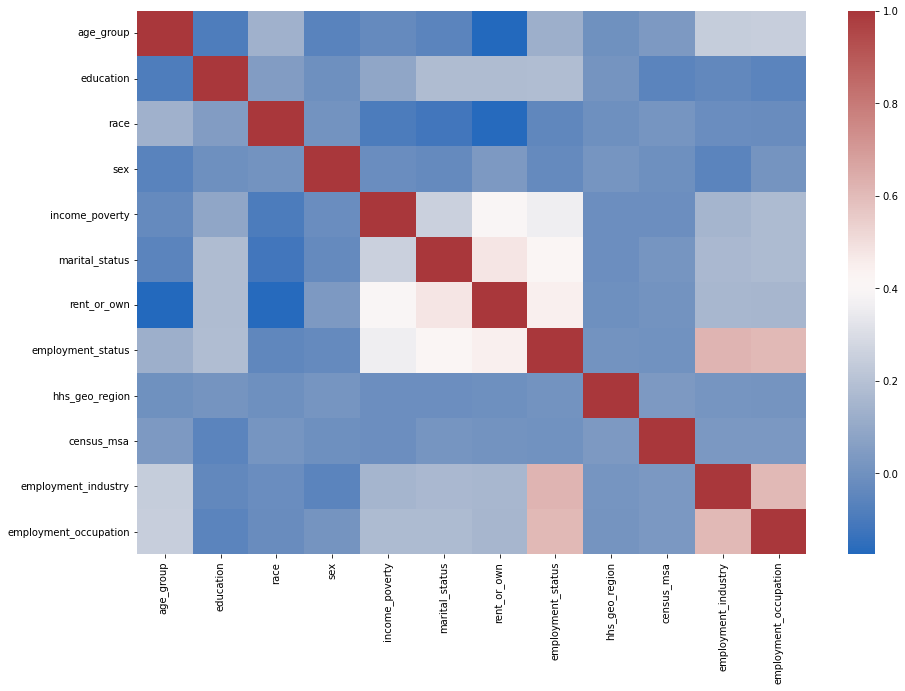

In [153]:
plt.figure(figsize=(15, 10))
h1n1_heat = sns.heatmap(non_num_corr,cmap=colormap)

In [154]:
train_features = numeric_cols.merge(non_numeric_cols,left_index=True,right_index=True)

In [155]:
train = train_features.merge(train_labels, on='respondent_id')

In [156]:
corr = train.corr()

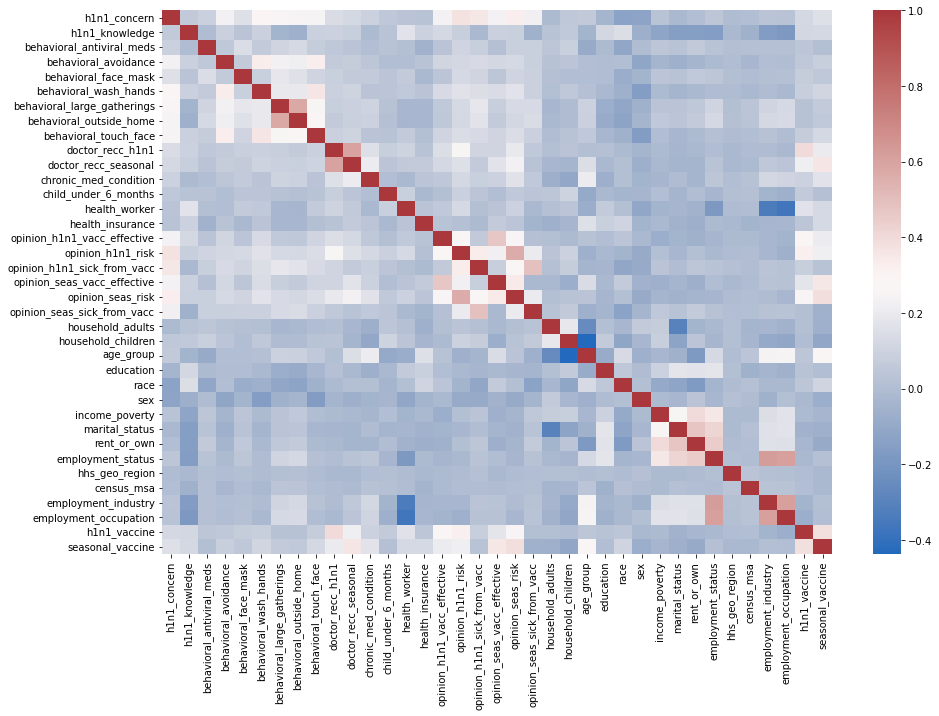

In [157]:
plt.figure(figsize=(15, 10))
corr_heat = sns.heatmap(corr,cmap=colormap)

In [158]:
corr.sort_values('h1n1_vaccine',ascending=False)['h1n1_vaccine']


h1n1_vaccine                   1.000000
doctor_recc_h1n1               0.394086
seasonal_vaccine               0.377143
opinion_h1n1_risk              0.320580
opinion_h1n1_vacc_effective    0.267352
opinion_seas_risk              0.255874
doctor_recc_seasonal           0.218976
opinion_seas_vacc_effective    0.177799
health_worker                  0.168056
h1n1_concern                   0.121574
h1n1_knowledge                 0.117771
chronic_med_condition          0.094360
opinion_h1n1_sick_from_vacc    0.074580
behavioral_wash_hands          0.074570
behavioral_touch_face          0.070855
behavioral_face_mask           0.070413
child_under_6_months           0.066712
behavioral_avoidance           0.046837
health_insurance               0.041891
age_group                      0.041074
race                           0.041061
behavioral_antiviral_meds      0.040226
education                      0.024694
behavioral_outside_home        0.022080
behavioral_large_gatherings    0.018089


In [159]:
top_seasonal = (corr.sort_values('seasonal_vaccine',ascending=False)
            .drop(['h1n1_vaccine','seasonal_vaccine'],
                  axis=0)['seasonal_vaccine'])

In [160]:
top_h1n1 = (corr.sort_values('h1n1_vaccine',ascending=False)
            .drop(['h1n1_vaccine','seasonal_vaccine'],
                  axis=0)['h1n1_vaccine'])

In [161]:
np.abs(top_seasonal)

opinion_seas_risk              0.386916
doctor_recc_seasonal           0.360696
opinion_seas_vacc_effective    0.358869
age_group                      0.277454
opinion_h1n1_risk              0.215650
opinion_h1n1_vacc_effective    0.203187
doctor_recc_h1n1               0.198560
chronic_med_condition          0.169465
h1n1_concern                   0.154488
health_worker                  0.126977
health_insurance               0.124929
behavioral_touch_face          0.119925
h1n1_knowledge                 0.119779
behavioral_wash_hands          0.112254
race                           0.101743
behavioral_avoidance           0.076130
behavioral_large_gatherings    0.063722
behavioral_outside_home        0.053287
behavioral_face_mask           0.050020
opinion_h1n1_sick_from_vacc    0.027964
child_under_6_months           0.013424
employment_status              0.011684
employment_industry            0.009639
behavioral_antiviral_meds      0.006013
employment_occupation          0.002697


In [162]:
top_seasonal = list(top_seasonal.index)[:5]
top_seasonal

['opinion_seas_risk',
 'doctor_recc_seasonal',
 'opinion_seas_vacc_effective',
 'age_group',
 'opinion_h1n1_risk']

In [163]:
top_h1n1 = list(top_h1n1.index)[:5]

In [164]:
top_features = top_seasonal + top_h1n1

In [165]:
list( set(top_seasonal).union(set(top_h1n1)))

['opinion_seas_risk',
 'doctor_recc_seasonal',
 'opinion_seas_vacc_effective',
 'age_group',
 'opinion_h1n1_risk',
 'opinion_h1n1_vacc_effective',
 'doctor_recc_h1n1']

In [173]:
models = [AdaBoostClassifier(learning_rate = 0.2, n_estimators = 30),
         AdaBoostClassifier(learning_rate = 0.2, n_estimators = 3000),
         AdaBoostClassifier(learning_rate = 0.2, n_estimators = 5000),
         AdaBoostClassifier(learning_rate = 0.2, n_estimators = 7000),
         AdaBoostClassifier(learning_rate = 0.2, n_estimators = 2000),
         AdaBoostClassifier(learning_rate = 0.25, n_estimators = 3000),
         AdaBoostClassifier(learning_rate = 0.25, n_estimators = 5000),
         AdaBoostClassifier(learning_rate = 0.25, n_estimators = 7000),
         AdaBoostClassifier(learning_rate = 0.25, n_estimators = 2000),
         AdaBoostClassifier(learning_rate = 0.1, n_estimators = 3000)]

In [ ]:
adaboost = AdaBoostClassifier(learning_rate = 0.2, n_estimators = 3000)
scores = {}

for model in models:
    numeric_preprocessing_steps = Pipeline([ 
                                            ('standard_scaler', StandardScaler())
                                            ])


    estimators = MultiOutputClassifier(
        estimator=model
    )
    full_pipeline = Pipeline([
        ("numeric", numeric_preprocessing_steps),
        ("estimators", estimators)])
    X_train, X_eval, y_train, y_eval = train_test_split(
#         train[top_features],
        train_features,
        train_labels,
        test_size=0.2,
        shuffle=True,
        stratify=train_labels,
    )



    full_pipeline.fit(X_train, y_train)
    preds = full_pipeline.predict_proba(X_eval)



    y_preds = pd.DataFrame(
        {
            "h1n1_vaccine": preds[0][:,1],
            "seasonal_vaccine": preds[1][:,1],

        },
        index= y_eval.index
    )
    score = roc_auc_score(y_eval, y_preds)
    scores[str(model)] = score
    print(scores)
scores

{'AdaBoostClassifier(learning_rate=0.2, n_estimators=30)': 0.8289011638409249}
{'AdaBoostClassifier(learning_rate=0.2, n_estimators=30)': 0.8289011638409249, 'AdaBoostClassifier(learning_rate=0.2, n_estimators=3000)': 0.84595284778945}


0.8368187744167227